# Running and Plotting Coeval Cubes

The aim of this tutorial is to introduce you to how `21cmFAST` does the most basic operations: producing single coeval cubes, and visually verifying them. It is a great place to get started with `21cmFAST`.

In [ ]:
%matplotlib inline
# We change the default level of the logger so that
# we can see what's happening with caching.
import logging

import matplotlib.pyplot as plt

logger = logging.getLogger("21cmFAST")
logger.setLevel(logging.INFO)

from tempfile import mkdtemp

import py21cmfast as p21c

# For plotting the cubes, we use the plotting submodule:
from py21cmfast import plotting

In [2]:
print(f' Using 21cmFAST version {p21c.__version__}')

 Using 21cmFAST version 3.4.1.dev701+g5c56dc00.d20250408


## Basic Usage

### Setting Up Inputs

All possible input parameters for a `21cmFAST` simulation are defined in the 
`InputParameters` object. This object is sub-divided into four constituent sections:
`cosmo_params`, `astro_params`, `matter_params`, and `astro_flags`, as well as the
`random_seed` and `node_redshifts`, which define the redshifts required for computing
the evolution of the simulation.

You can create a full `InputParameters` object quickly and easily in a few ways.
The first is simply to instantiate it directly. Here, the only _required_ parameter
is the random seed:

You can check out the full set of default parameters:

In [3]:
inputs = p21c.InputParameters(random_seed=12345)

To set any desired parameters, the easiest way is to pass them at instantiation:

In [4]:
inputs = p21c.InputParameters(
    matter_params=p21c.MatterParams.new(HII_DIM=150), random_seed=12345
)

However, you can also get a new set of inputs by evolving an existing set:

In [5]:
inputs_large = inputs.evolve_input_structs(BOX_LEN=1000.0, HII_DIM=500, DIM=1000)

In this case, you don't need to specify which sub-category of parameter each updated
parameter belongs to. Nevertheless, you can also update those sub-categories directly:

In [6]:
inputs_small = inputs_large.clone(matter_params=p21c.MatterParams())

However, probably the easiest way to start a new simulation is to base your parameters
on a particular template. A number of templates are built-in, spanning the range of 
simulations from small and fast to large and sophisticated:

In [7]:
for _template in p21c.run_templates.list_templates():
    print(f'name: {_template['name']}')
    print(f'description: {_template['description']}')
    print(f'---------')
    pass

name: simple
description: A simple 21cmFAST run with no minihalos, discrete halos, recombinations or spin temperature fluctuations
---------
name: const-zeta
description: A 21cmFAST run with constant ionising efficiency for halos of all mass
---------
name: latest
description: Our latest fiducial run without discrete halos, includes recominations and spin temperature fluctuations
---------
name: mini
description: A run including minihalos
---------
name: latest-dhalos
description: Our latest fiducial run with discrete halos, recominations and spin temperature fluctuations
---------
name: mini-dhalos
description: Run with discrete halos, including the molecularly cooled galaxy component
---------
name: Park19
description: Exact fiducial parameters from Park et al 2019. Disables modules implemented afterwards
---------
name: Qin20
description: Exact fiducial parameters from Qin et al 2020. Disables modules implemented afterwards
---------
name: Munoz21
description: Exact fiducial paramet

In this tutorial, we want something small and fast:

In [8]:
inputs = p21c.InputParameters.from_template(
    "simple", random_seed=1234
).evolve_input_structs(BOX_LEN=100.0, DIM=200, HII_DIM=100)

<div class="alert alert-info">

Note

Why do we require you to specify the random seed explicitly? Because doing so minimizes
surprises. As we will see, `21cmFAST` attempts to cache its results, and can therefore
return the same simulation when the same parameters are given. This is sometimes 
surprising, if you were trying to generate multiple realizations of simulations with the 
same parameters. Always explicitly specifying the seed requires *you* to take control
of this behavior.

</div>

#### Specifying the evolution

While the simulations we will perform in this tutorial will not require any evolution
over cosmic time, there are several situations in which this is required:

1. The desired output is a lightcone that evolves over redshift.
2. The input options (generally toggled via parameters in `InputParameters.astro_flags`)
   specify physical processes that can only be computed by integrating over cosmic 
   history. For example, computing spin temperature fluctuations or using a population
   of mini-halos will require this.

To check if your simulation parameters *require* evolution, you can do:

In [9]:
inputs.evolution_required

False

Models that _do_ require evolution also require a specification for which redshifts to
use when scrolling through cosmic history. These will be set by default when using such
a model, for example:

In [10]:
inputs_with_evolution = p21c.InputParameters.from_template("Munoz21", random_seed=123)

In [11]:
inputs_with_evolution.evolution_required

True

In [12]:
print(f'Number of redshift nodes: {len(inputs_with_evolution.node_redshifts)}')
print(f'Max redshift: {max(inputs_with_evolution.node_redshifts)}')
print(f'Min redshift: {min(inputs_with_evolution.node_redshifts)}')

Number of redshift nodes: 88
Max redshift: 35.40225603367622
Min redshift: 5.5


You can specify these "node" redshifts yourself:

In [13]:
p21c.InputParameters.from_template(
    "Munoz21", random_seed=123, node_redshifts=(5, 6, 7, 10, 15, 25, 35)
).node_redshifts

(35.0, 25.0, 15.0, 10.0, 7.0, 6.0, 5.0)

In [14]:
p21c.InputParameters.from_template(
    "Munoz21", random_seed=123, node_redshifts=p21c.get_logspaced_redshifts(min_redshift=5,max_redshift=35,z_step_factor=1.1)
).node_redshifts

(35.69545426904878,
 32.35950388095343,
 29.326821709957663,
 26.569837918143328,
 24.063489016493932,
 21.78499001499448,
 19.713627286358616,
 17.830570260326013,
 16.11870023666001,
 14.56245476060001,
 13.147686146000009,
 11.861532860000008,
 10.692302600000007,
 9.629366000000005,
 8.663060000000003,
 7.784600000000003,
 6.986000000000002,
 6.260000000000002,
 5.6000000000000005,
 5.0)

When doing so, remember that accuracy is decreased when fewer nodes are used, especially
during times when the universe is changing more rapidly (e.g. throughout reionization).
Also keep in mind that the redshifts must _at least_ extend to `Z_HEAT_MAX`: a parameter
that defines the redshift beyond which background fluctuations are considered negligible.
An error will be raised if this is not respected.

In [15]:
finer_zgrid = p21c.InputParameters(
    random_seed=123,
    node_redshifts=p21c.get_logspaced_redshifts(min_redshift=5.,max_redshift=25,z_step_factor=1.02),
    astro_flags={"USE_TS_FLUCT": True},
    matter_params={"Z_HEAT_MAX": 25.0},
)

## Run a simulation using `run_coeval` and `generate_coeval`

The simplest (and typically most efficient) way to produce a coeval cube is simply to 
use the `run_coeval` method. This consistently performs all steps of the calculation, 
re-using any data that it can without re-computation or increased memory overhead.

First we make a temporary cache to store our fields, in larger runs 21cmFAST can store its outputs in an `OutputCache` to avoid unnecessary regeneration

In [16]:
cache = p21c.OutputCache(mkdtemp())

In [17]:
coevals = p21c.run_coeval(
    inputs=inputs,
    out_redshifts=[8, 9, 10],
    cache=cache,
)

The `generate_coeval` method is a generator, which can be called as follows:

In [18]:
coevals = []
for coeval,in_outputs in p21c.generate_coeval(
    inputs=inputs,
    out_redshifts=[8, 9, 10],
    cache=cache,
):
    if in_outputs:
        coevals.append(coeval)
        

Note that this run was much faster, since we cached the outputs from the previous run, and they were simply loaded instead of re-calculated

There are a number of possible inputs for `generate/run_coeval`, which you can check out either in the [API reference](../reference/py21cmfast.html) or by calling `help(p21c.run_coeval)`. 

Notably, in our case here, the `out_redshifts` must be given: these are the redshifts
at which we compute the coeval boxes. When the simulation requires evolution over 
cosmic history, coeval boxes will be computed at every node _as well as_ any 
`out_redshifts` specified. 

Since the function is a generator, it yields a `Coeval` box on each iteration. These
boxes can be saved or post-processed before completing the next iteration, allowing
arbitrarily flexible computations to be performed. The second returned values is a 
boolean which tells you whether you are at a requested output point in `out_redshifts`.

We've also given a `cache` parameter: this specifies a directory in which the various
component calculations of this simulation will be cached. By default, this will occur
in the current directory, but here we are using a temporary directory for convenience.
While by default all sub-components are written into the cache, this can be turned off
altogether, or toggled per subcomponent. The main reason to use the cache is if you 
might want to re-use simulated component boxes in other simulations in the future.
A prime example of this is the `InitialConditions`, for which a single simulation can
be used for a multitude of astrophysical simulations with varying `AstroParams`. 

The output on each iteration is, as we have mentioned, a `Coeval` object. This is a simple
object that contains a number of 3D arrays of data, one for each of the component fields
simulated. They can be accessed as attributes of the object:

In [19]:
coevals[0].redshift

10.0

A list of all simulated fields can be accessed:

In [20]:
coevals[0].get_fields()

['lowres_density',
 'lowres_vx',
 'lowres_vy',
 'lowres_vz',
 'hires_density',
 'hires_vx',
 'hires_vy',
 'hires_vz',
 'lowres_vx_2LPT',
 'lowres_vy_2LPT',
 'lowres_vz_2LPT',
 'hires_vx_2LPT',
 'hires_vy_2LPT',
 'hires_vz_2LPT',
 'lowres_vcb',
 'density',
 'velocity_z',
 'velocity_x',
 'velocity_y',
 'xH_box',
 'Gamma12_box',
 'MFP_box',
 'z_re_box',
 'dNrec_box',
 'temp_kinetic_all_gas',
 'Fcoll',
 'Fcoll_MINI',
 'brightness_temp',
 'Ts_box',
 'x_e_box',
 'Tk_box',
 'J_21_LW_box',
 'halo_mass',
 'halo_stars',
 'halo_stars_mini',
 'count',
 'halo_sfr',
 'halo_sfr_mini',
 'halo_xray',
 'n_ion',
 'whalo_sfr']

The `Coeval` object also maintains a reference to the input parameters:

In [21]:
coevals[0].inputs

cosmo_params: CosmoParams(SIGMA_8=0.8102, hlittle=0.6766, OMm=0.30964144154550644, OMb=0.04897468161869667, POWER_INDEX=0.9665, OMn=0.0, OMk=0.0, OMr=8.6e-05, OMtot=1.0, Y_He=0.24, wl=-1.0)
matter_params: MatterParams(BOX_LEN=100.0, HII_DIM=100, DIM=200, NON_CUBIC_FACTOR=1.0, N_THREADS=1, SAMPLER_MIN_MASS=100000000.0, SAMPLER_BUFFER_FACTOR=2.0, N_COND_INTERP=200, N_PROB_INTERP=400, MIN_LOGPROB=-12.0, HALOMASS_CORRECTION=0.89, PARKINSON_G0=1.0, PARKINSON_y1=0.0, PARKINSON_y2=0.0, Z_HEAT_MAX=35.0, ZPRIME_STEP_FACTOR=1.02, INITIAL_REDSHIFT=300.0, DELTA_R_FACTOR=1.1, DENSITY_SMOOTH_RADIUS=0.2, DEXM_OPTIMIZE_MINMASS=100000000000.0, DEXM_R_OVERLAP=2.0, CORR_STAR=0.5, CORR_SFR=0.2, CORR_LX=0.2)
matter_flags: MatterFlags(HMF='ST', USE_RELATIVE_VELOCITIES=False, POWER_SPECTRUM='EH', PERTURB_ON_HIGH_RES=False, NO_RNG=False, USE_INTERPOLATION_TABLES='hmf-interpolation', MINIMIZE_MEMORY=False, KEEP_3D_VELOCITIES=False, SAMPLE_METHOD='MASS-LIMITED', FILTER='spherical-tophat', HALO_FILTER='spherical

We can also save/load a Coeval object to disk:

In [22]:
coevals[0].save(cache.direc / "coeval.h5")

Note that, if you are also using the cache (as we are), then saving the `Coeval` object
creates redundant data on disk. The files created by `Coeval` are more convenient for 
saving, sharing and using in further post-processing, but are not easily used for 
caching purposes.

The file that we wrote can be easily read:

In [23]:
coeval10 = p21c.Coeval.from_file(cache.direc / "coeval.h5")

Some convenient plotting functions exist in the `plotting` module. These can work directly on `Coeval` objects, or any of the output structs (as we'll see further on in the tutorial). By default the `coeval_sliceplot` function will plot the `brightness_temp`, using the standard traditional colormap:

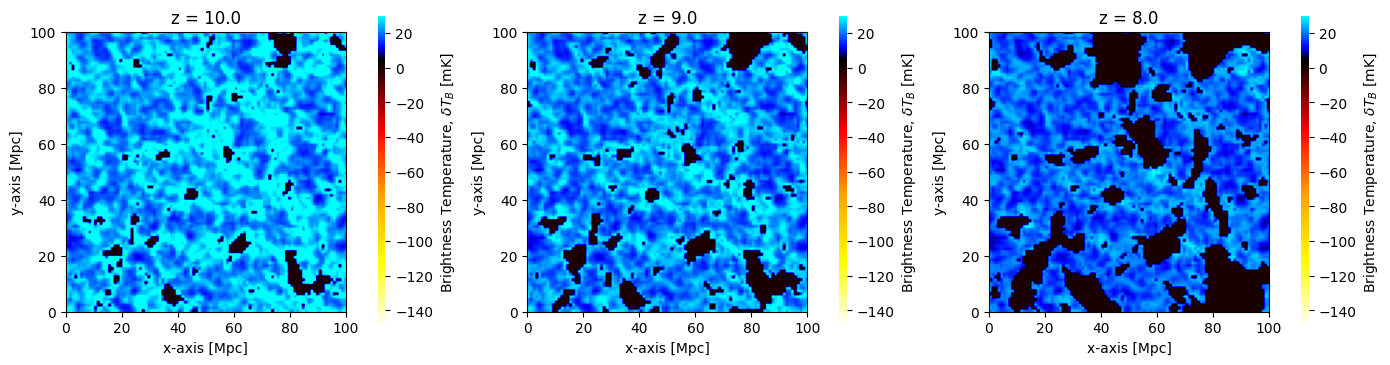

In [24]:
fig, ax = plt.subplots(1, 3, figsize=(14, 4))
for i, coeval in enumerate(coevals):
    plotting.coeval_sliceplot(coeval, ax=ax[i], fig=fig)
    plt.title(f"z = {coeval.redshift}")
plt.tight_layout()

Any 3D field can be plotted, by setting the `kind` argument. For example, we could alternatively have plotted the dark matter density cubes perturbed to each redshift:

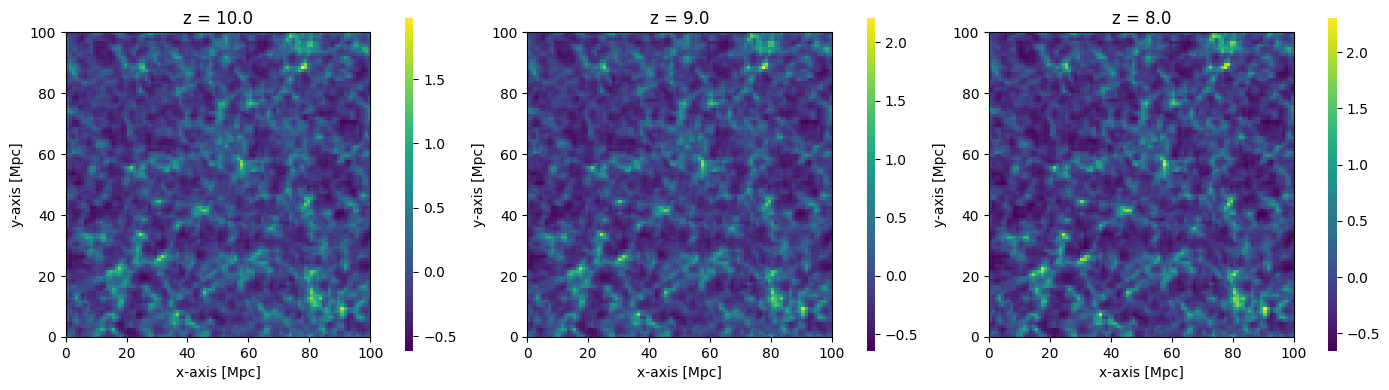

In [25]:
fig, ax = plt.subplots(1, 3, figsize=(14, 4))
for i, coeval in enumerate(coevals):
    plotting.coeval_sliceplot(coeval, kind="density", ax=ax[i], fig=fig)
    plt.title(f"z = {coeval.redshift}")
plt.tight_layout()

To see more options for the plotting routines, see the [API Documentation](../reference/_autosummary/py21cmfast.plotting.html).

This brief example covers most of the basic usage of `21cmFAST` (at least with `Coeval` objects -- there are also `Lightcone` objects for which there is a separate tutorial). 

For the rest of the tutorial, we'll cover a more advanced usage, in which each step of the calculation is done independently.

## Advanced Step-by-Step Usage

Most users most of the time will want to use the high-level `run_coeval` function from the previous section. However, there are several independent steps when computing the brightness temperature field, and these can be performed one-by-one, adding any other effects between them if desired. In this section, we'll go through in more detail how to use the lower-level methods.

Each step is performed by running a function which will return a single object. 
Every major function returns an object of the same fundamental class (an ``OutputStruct``) 
which has methods to share its underlying data with the backend C code, and maintain 
knowledge of the state of its memory.

As we move through each step, we'll outline some extra details, hints and tips about using these inputs and outputs.

The first thing to do is to set up the input parameters. Here, we'll use the same
basic set of parameters as we used in `run_coeval`, but with a different random seed, 
which ensures that we compute all new boxes.

In [26]:
new_inputs = inputs.clone(random_seed=42)

### Initial Conditions

The first step is to get the initial conditions, which defines the *cosmological* density field before any redshift evolution is applied.

In [27]:
initial_conditions = p21c.compute_initial_conditions(
    inputs=new_inputs, cache=cache, write=True
)

As we said, all of these "single field" functions return objects of type `OutputStruct`.
These objects have a few things in common. For example, they hold a reference to their
input parameters:

In [28]:
initial_conditions.inputs.matter_params.HII_DIM

100

More importantly, once computed, they hold the simulated data. This data is held in 
special `Array` objects, and all the available simulated fields can be accessed through
the `.arrays` attribute:

In [29]:
initial_conditions.arrays.keys()

dict_keys(['lowres_density', 'lowres_vx', 'lowres_vy', 'lowres_vz', 'hires_density', 'hires_vx', 'hires_vy', 'hires_vz', 'lowres_vx_2LPT', 'lowres_vy_2LPT', 'lowres_vz_2LPT', 'hires_vx_2LPT', 'hires_vy_2LPT', 'hires_vz_2LPT'])

As we mentioned, the values of these attributes are _not_ numpy arrays, but custom
`Array` objects. These have the ability to track their state: whether they initialized,
computed, stored on disk, etc., and they also know how to share themselves with the 
C backend. While this is useful for the simulation, it is not that helpful to _you_ as 
a user. That's OK: these objects aren't really meant to be the primary way you interact
with `21cmFAST` as a user. 

However, to get at the underlying numpy array, you can use the `.get()` method:

In [30]:
initial_conditions.get("lowres_density").mean()

np.float32(0.00010171841)

This has the handy feature that even if the array has been purged from memory but stored
on disk, the `.get()` method will still return the array (it will read it from disk,
and store it back on the object until you tell the object to purge it again).

For example:

In [31]:
initial_conditions.purge()

Once purged, the array's state shows that it is not initialized or in memory, but it
is stored on disk (because we passed `write=True` when computing it):

In [32]:
initial_conditions.lowres_density.state

ArrayState(initialized=False, c_memory=False, computed_in_mem=False, on_disk=True)

However, when we use `.get()`, the array is re-loaded:

In [33]:
initial_conditions.get("lowres_density").mean()

np.float32(0.00010171841)

In [34]:
initial_conditions.lowres_density.state

ArrayState(initialized=True, c_memory=False, computed_in_mem=True, on_disk=True)

The `coeval_sliceplot` function also works on `OutputStruct` objects (as well as the `Coeval` object as we've already seen). It takes the object, and a specific field name. By default, the field it plots is the _first_ field in `arrays` (for any `OutputStruct`).

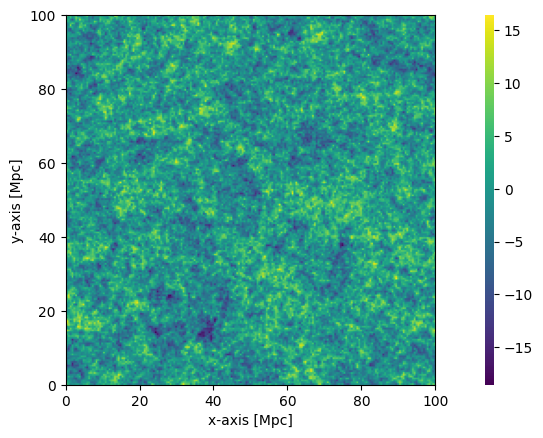

In [35]:
plotting.coeval_sliceplot(initial_conditions, "hires_density");

### Perturbed Field

After obtaining the initial conditions, we need to *perturb* the field to a given redshift (i.e. the redshift we care about). This step clearly requires the results of the previous step, which we can easily just pass in. Let's do that:

In [36]:
perturbed_field = p21c.perturb_field(
    redshift=8.0, initial_conditions=initial_conditions
)

Note that we didn't need to pass in any input parameters, because they are all contained in the `initial_conditions` object itself. The random seed is also taken from this object.

Again, the output is an `OutputStruct`, so we can view its fields:

In [37]:
perturbed_field.arrays.keys()

dict_keys(['density', 'velocity_z'])

This time, it has only density and velocity (the velocity direction is chosen without loss of generality). Let's view the perturbed density field:

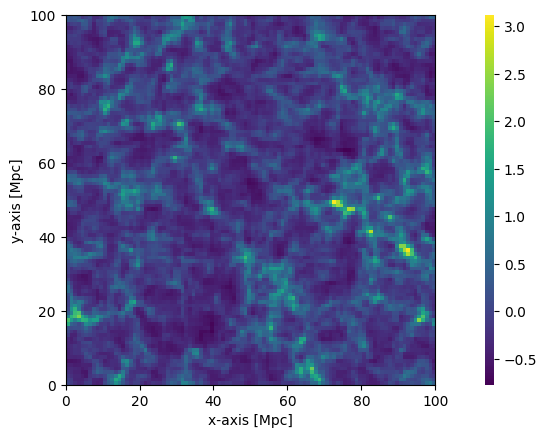

In [38]:
plotting.coeval_sliceplot(perturbed_field, "density");

It is clear here that the density used is the *low*-res density, but the overall structure of the field looks very similar.

### Ionization Field

Next, we need to ionize the box. This is where things get a little more tricky. 
In the simplest case we are using in this tutorial, the ionization occurs at the 
*saturated limit*, which means we can safely ignore the contribution of the spin 
temperature fluctuations. 
This means we can directly calculate the ionization on the density/velocity fields that 
we already have.

In [39]:
ionized_field = p21c.compute_ionization_field(
    initial_conditions=initial_conditions, perturbed_field=perturbed_field
)

Let's see the fieldnames:

In [40]:
ionized_field.arrays.keys()

dict_keys(['xH_box', 'Gamma12_box', 'MFP_box', 'z_re_box', 'dNrec_box', 'temp_kinetic_all_gas', 'Fcoll'])

Let's plot the neutral fraction:

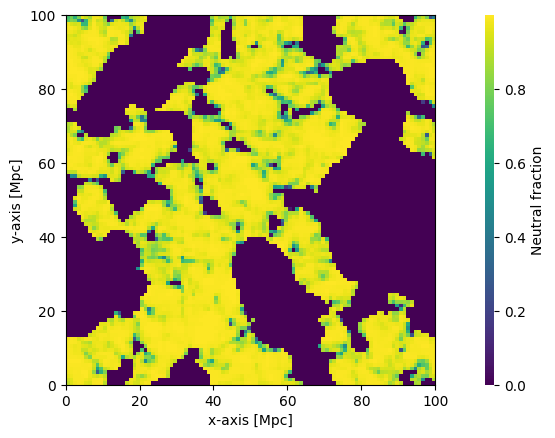

In [41]:
plotting.coeval_sliceplot(ionized_field, "xH_box");

### Brightness Temperature

Now we can use what we have to get the brightness temperature:

In [42]:
brightness_temp = p21c.brightness_temperature(
    ionized_box=ionized_field, perturbed_field=perturbed_field
)

This has only a single field, ``brightness_temp``:

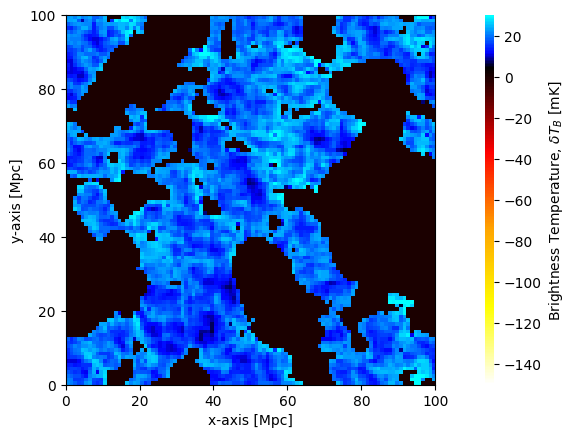

In [43]:
plotting.coeval_sliceplot(brightness_temp);